In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
for directory in os.listdir('drive/MyDrive/face_data'):
  print(directory)

negative
positive
anchor


In [6]:
neg_path = r'drive/MyDrive/face_data/negative'
pos_path= r'drive/MyDrive/face_data/positive'
anch_path= r'drive/MyDrive/face_data/anchor'
print(len([entry for entry in os.listdir(neg_path) if os.path.isfile(os.path.join(neg_path, entry))]))

1364


# Data Augmentation

In [7]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

# Load and Preprocess data

In [8]:
anchor = tf.data.Dataset.list_files(anch_path+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path+'/*.jpg').take(300)

In [9]:
dir_test = anchor.as_numpy_iterator()

In [10]:
dir_test.next()

b'drive/MyDrive/face_data/anchor/3164.jpg'

In [11]:
def preprocess(file_path):

    byte_img = tf.io.read_file(file_path)

    img = tf.io.decode_jpeg(byte_img)
  
    img = tf.image.resize(img, (105,105))
    img = img / 255.0
    return img

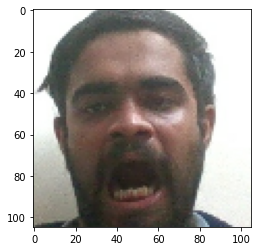

In [12]:
img=preprocess('drive/MyDrive/face_data/anchor/5125.jpg')
plt.imshow(img)

In [13]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [15]:
 samp=data.as_numpy_iterator()

In [16]:
temp= samp.next()

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*temp)

In [19]:
res

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        ...,
 
        [[0.5880309 , 0.58448285

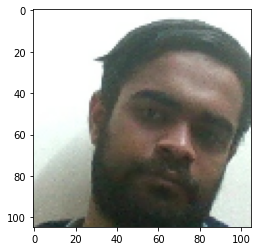

In [20]:
plt.imshow(res[0])

In [21]:
res[2]

1.0

In [22]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [23]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [24]:
sam = data.as_numpy_iterator()

In [25]:
len(sam.next())

3

In [26]:
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

In [27]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [28]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building Model

In [29]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [30]:
embedding = make_embedding()

In [31]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [32]:
class L1Dist(Layer):
  
    def __init__(self, **kwargs):
        super().__init__()
     
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [33]:
siemese_layer = L1Dist()

In [34]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [35]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [36]:
distances = siemese_layer(inp_embedding, val_embedding)

In [37]:
classifier = Dense(1, activation='sigmoid')(distances)

In [38]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [39]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [40]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

In [41]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siemese_model=siamese_network)

In [43]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_network(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_network.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_network.trainable_variables))
        
    # Return loss
    return loss

In [44]:
from tensorflow.keras.metrics import Precision, Recall

In [45]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_network.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [48]:
EPOCHS = 50

In [49]:
train(train_data, EPOCHS)


 Epoch 1/50
27/27 [==============================] - 9s 325ms/step
2.551209e-05 1.0 1.0

 Epoch 2/50
27/27 [==============================] - 9s 317ms/step
5.467789e-05 1.0 1.0

 Epoch 3/50
27/27 [==============================] - 9s 326ms/step
0.0026928284 1.0 1.0

 Epoch 4/50
27/27 [==============================] - 9s 320ms/step
3.597399e-05 1.0 1.0

 Epoch 5/50
27/27 [==============================] - 9s 320ms/step
0.00015767419 1.0 1.0

 Epoch 6/50
27/27 [==============================] - 9s 317ms/step
8.940698e-08 1.0 1.0

 Epoch 7/50
27/27 [==============================] - 9s 318ms/step
2.1308751e-06 1.0 1.0

 Epoch 8/50
27/27 [==============================] - 9s 323ms/step
2.801434e-06 1.0 1.0

 Epoch 9/50
27/27 [==============================] - 9s 314ms/step
-0.0 1.0 1.0

 Epoch 10/50
27/27 [==============================] - 8s 311ms/step
1.0430815e-07 1.0 1.0

 Epoch 11/50
27/27 [==============================] - 9s 322ms/step
1.3411403e-05 1.0 1.0

 Epoch 12/50
27/27 [==

In [50]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_network.predict([test_input, test_val])

1/1 [==============================] - 0s 22ms/step


In [55]:
y_pred=[1 if prediction > 0.5 else 0 for prediction in y_hat ]
y_pred

[0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]

In [52]:
y_true

array([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [53]:
# r = Recall()
# p = Precision()

# for test_input, test_val, y_true in test_data.as_numpy_iterator():
#     yhat = siamese_network.predict([test_input, test_val])
#     r.update_state(y_true, yhat)
#     p.update_state(y_true,yhat) 

# print(r.result().numpy(), p.result().numpy())

# Visualizing Through Test Images

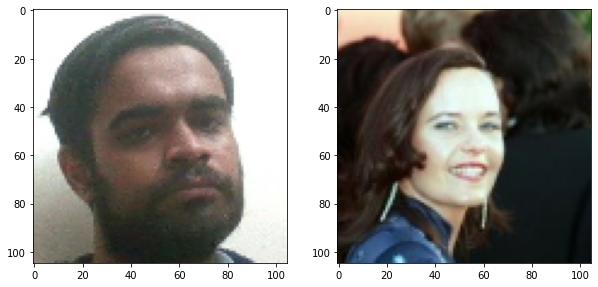

prediction:  0


In [56]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()
print("prediction: ", y_pred[0])

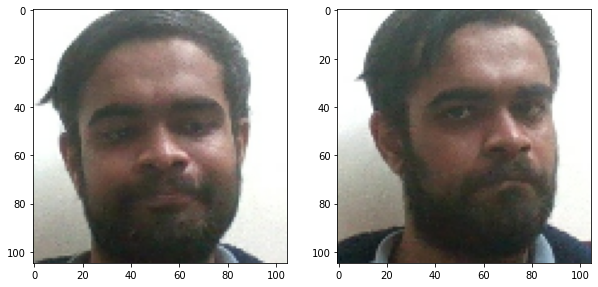

prediction:  1


In [57]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()
print("prediction: ", y_pred[1])

In [59]:
siamese_network.save('drive/MyDrive/siamesemodelv2.h5')

In [60]:
siamese_model = tf.keras.models.load_model('drive/MyDrive/siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [61]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][